# Import libraries

In [ ]:
!pip install pandas_ta
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=fec793b3b85a5b8a795724e637feb8d4a888138b16e6a36efbf81dcb2b229eac
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinu

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import pandas_ta as ta
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import random
from copy import deepcopy
from torch.optim import Adam
from torch.nn import MSELoss
import copy

## Amazon

### Data Insights

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
amazon = pd.read_csv('/content/drive/MyDrive/ML_project/Data/Amazon_weekly.csv')

In [ ]:
amazon.head()

,Date,Open,High,Low,Close,Volume
0,1997-05-18,18.000,30.00,18.000,1.7292,7238000
1,1997-05-25,21.125,21.25,15.750,1.5000,4836500
2,1997-06-01,18.125,19.75,17.500,1.5000,1611600
3,1997-06-08,18.125,20.50,16.500,1.6563,1527900
4,1997-06-15,19.875,20.50,18.375,1.5834,943700


In [ ]:
amazon.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

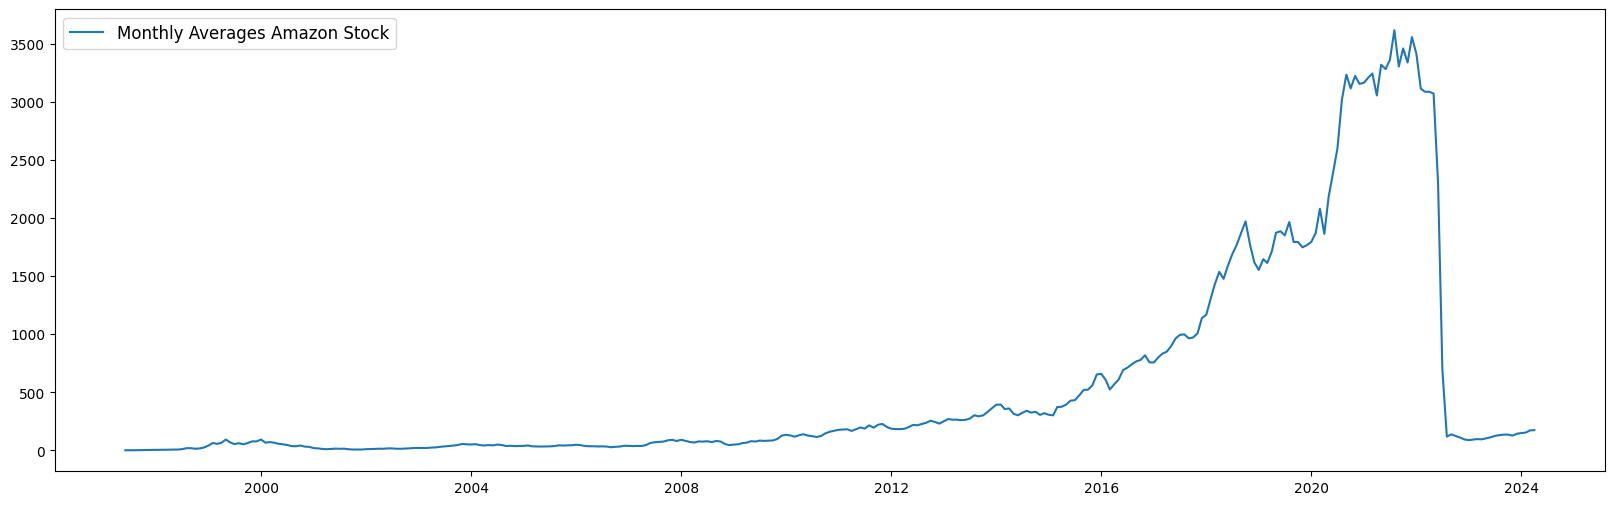

In [ ]:
amazon['Date'] = pd.to_datetime(amazon.Date)
newamazon = amazon.set_index('Date')
# Resample the data to the monthly level
monthly_data = newamazon[['Close', 'Open', 'High', 'Low', 'Volume']].resample('M').mean()
##Monthly Stock Price
fig = plt.figure(figsize=(20,6))
plt.plot(monthly_data['Close'],label='Monthly Averages Amazon Stock')
plt.legend(prop={'size': 12})
plt.show()

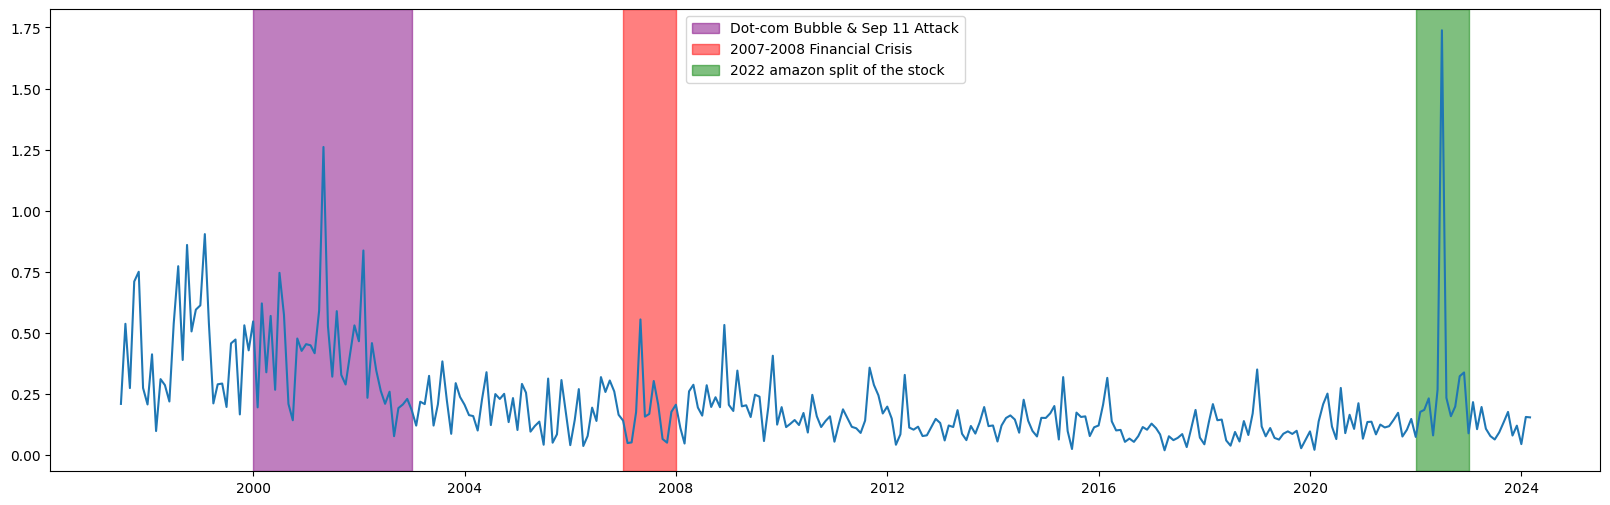

In [ ]:
# Calculate weekly returns using percentage change
weekly_returns = newamazon['Close'].pct_change()
weekly_returns.dropna(inplace=True)

# Resample to monthly data and calculate the standard deviation as a measure of volatility
# Then annualize the monthly volatility
monthly_volatility = weekly_returns.resample("M").std() * np.sqrt(12)

# Visualize major market events reflected in volatility
plt.figure(figsize=(20, 6))
plt.plot(monthly_volatility)
plt.axvspan('2000', '2003', color='purple', alpha=.5)
plt.axvspan('2007', '2008', color='red', alpha=.5)
plt.axvspan('2022', '2023', color='green', alpha=.5)
#plt.title("Monthly Annualized Volatility")

# Add legend for major market events
l1 = mpatches.Patch(color='purple', alpha=.5, label="Dot-com Bubble & Sep 11 Attack")
l2 = mpatches.Patch(color='red', alpha=.5, label="2007-2008 Financial Crisis")
l3 = mpatches.Patch(color='green', alpha=.5, label="2022 amazon split of the stock")
plt.legend(handles=[l1, l2, l3])

plt.show()

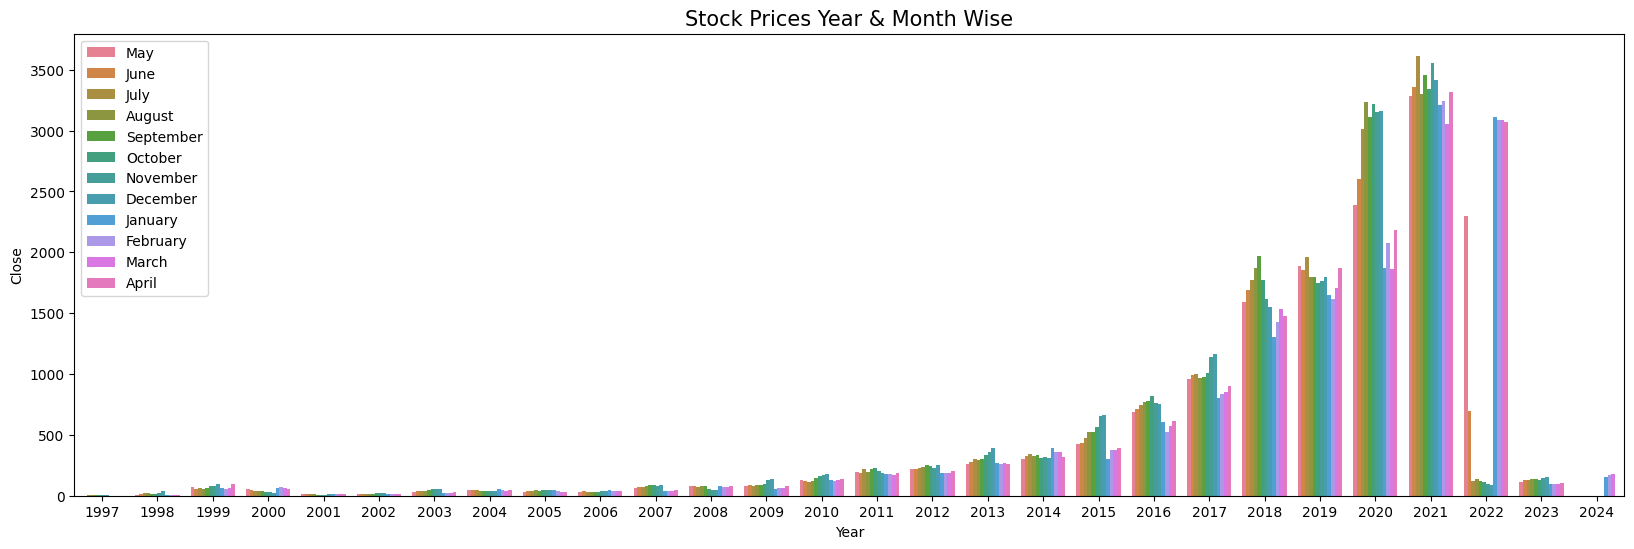

In [ ]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['Quarter'] = monthly_data.index.quarter
fig, ax = plt.subplots(figsize=(20,6))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="Close",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.show()

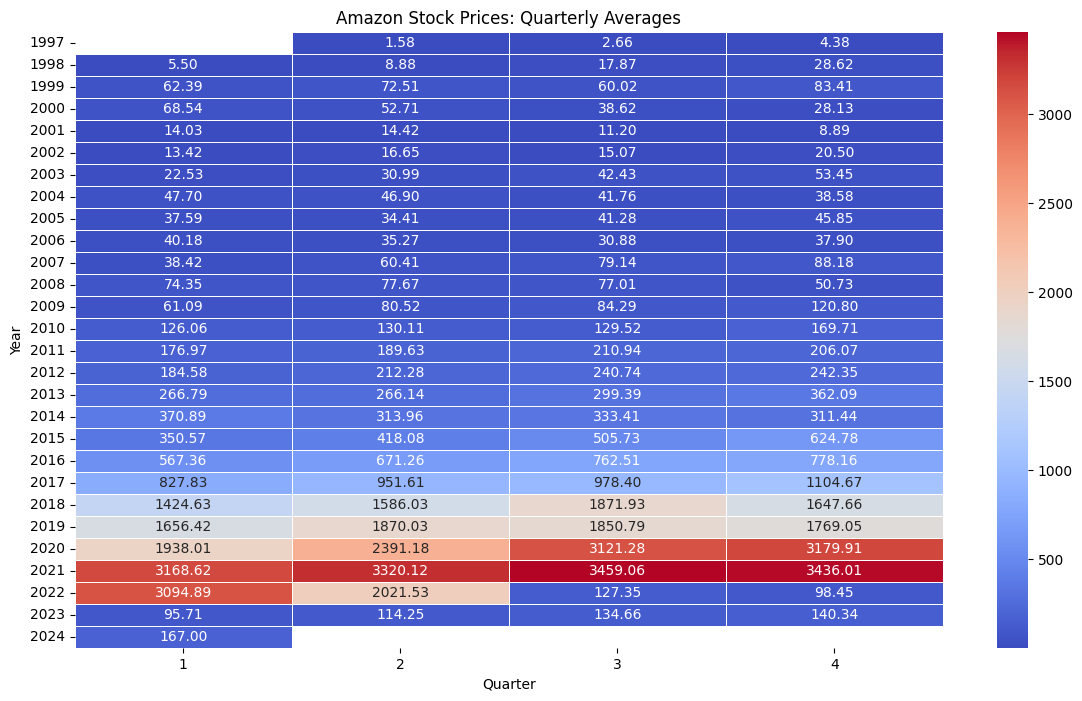

In [ ]:
quarter = monthly_data.groupby(["Year", "Quarter"])["Close"].mean().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(quarter, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
plt.title("Amazon Stock Prices: Quarterly Averages")
plt.show()

### Data Preparation

#### Target Construction

In [ ]:
# Create Log(Return)
# Calculate logarithmic returns
amazon['Log_Return'] = np.log(amazon['Close'] / amazon['Close'].shift(1))
amazon['Log_Return'].fillna(0, inplace=True)  # Handle NaN values resulting from the shift

#### Covariates construction

In [ ]:
# Calculate Simple Moving Average (SMA)
amazon['SMA_50'] = ta.sma(amazon['Close'], length=50)  # 50-period SMA
amazon['SMA_200'] = ta.sma(amazon['Close'], length=200)  # 200-period SMA

# Calculate Exponential Moving Average (EMA)
amazon['EMA_12'] = ta.ema(amazon['Close'], length=12)  # 12-period EMA
amazon['EMA_26'] = ta.ema(amazon['Close'], length=26)  # 26-period EMA

# Calculate the Stochastic Oscillator components
stoch = ta.stoch(amazon['High'], amazon['Low'], amazon['Close'])
amazon = amazon.join(stoch)

# Calculate Relative Strength Index (RSI)
amazon['RSI_14'] = ta.rsi(amazon['Close'], length=14)  # 14-period RSI

# Calculate Moving Average Convergence Divergence (MACD)
macd = ta.macd(amazon['Close'])
amazon = amazon.join(macd)

In [ ]:
amazon['Date'] = pd.to_datetime(amazon['Date'])
amazon.set_index('Date', inplace=True)

In [ ]:
# Handle NaN:
amazon.dropna(inplace=True)

In [ ]:
amazon.shape

(1200, 16)

In [ ]:
dates = amazon.index

In [ ]:
# Calculate split indices
split_idx_train = int(len(amazon) * 0.7)
split_idx_val = int(len(amazon) * 0.9)

# Drop the specified columns and define the features and labels
X_amazon = amazon.drop(['Log_Return'], axis=1)
y_amazon = amazon['Log_Return']  # Log_Return as the target variable

# Ensure that indices are reset before splitting to avoid potential issues
X_amazon.reset_index(drop=True, inplace=True)
y_amazon.reset_index(drop=True, inplace=True)

# Split into training, validation, and testing sets
X_amazon_train = X_amazon.iloc[:split_idx_train, :]
X_amazon_val = X_amazon.iloc[split_idx_train:split_idx_val, :]
X_amazon_test = X_amazon.iloc[split_idx_val:, :]

y_amazon_train = y_amazon.iloc[:split_idx_train]
y_amazon_val = y_amazon.iloc[split_idx_train:split_idx_val]
y_amazon_test = y_amazon.iloc[split_idx_val:]

In [ ]:
amazon_dates_test = dates[split_idx_val:]

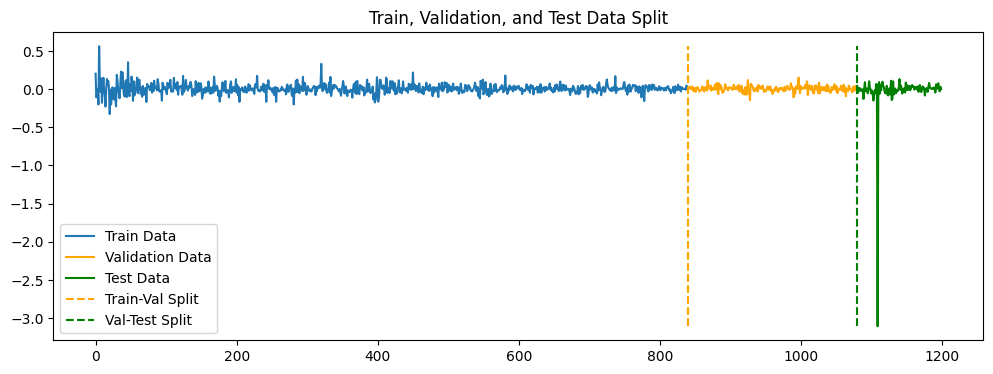

In [ ]:
# Indices for plotting
x_train = np.arange(len(y_amazon_train))
x_val = np.arange(len(y_amazon_train), len(y_amazon_train) + len(y_amazon_val))
x_test = np.arange(len(y_amazon_train) + len(y_amazon_val), len(y_amazon))

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(x_train, y_amazon_train, label="Train Data")
plt.plot(x_val, y_amazon_val, color='orange', label="Validation Data")
plt.plot(x_test, y_amazon_test, color='green', label="Test Data")
plt.vlines(len(y_amazon_train), ymin=min(y_amazon.min(), y_amazon.min(), y_amazon.min()), ymax=max(y_amazon.max(), y_amazon.max(), y_amazon.max()), label='Train-Val Split', linestyles='dashed', colors='orange')
plt.vlines(len(y_amazon_train) + len(y_amazon_val), ymin=min(y_amazon.min(), y_amazon.min(), y_amazon.min()), ymax=max(y_amazon.max(), y_amazon.max(), y_amazon.max()), label='Val-Test Split', linestyles='dashed', colors='green')
plt.legend()
plt.title("Train, Validation, and Test Data Split")
plt.show()

### Data Preprocessing

In [ ]:
from sklearn.preprocessing import power_transform

# Fit the transformer on the training data and transform it
X_amazon_train_transformed = power_transform(X_amazon_train.to_numpy(), method='yeo-johnson')

# Transform the validation data using the same transformer
X_amazon_val_transformed = power_transform(X_amazon_val.to_numpy(), method='yeo-johnson')

# Transform the test data using the same transformer
X_amazon_test_transformed = power_transform(X_amazon_test.to_numpy(), method='yeo-johnson')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_amazon_train_scaled = scaler.fit_transform(X_amazon_train_transformed)

# Transform the val data using the same scaler
X_amazon_val_scaled = scaler.transform(X_amazon_val_transformed)

# Transform the test data using the same scaler
X_amazon_test_scaled = scaler.transform(X_amazon_test_transformed)

In [ ]:
print(X_amazon_train_scaled.shape)
print(X_amazon_val_scaled.shape)
print(X_amazon_test_scaled.shape)

(840, 15)
(240, 15)
(120, 15)


### Models

#### Loss function: RMSE

##### RNNs

In [ ]:
!ls "/content/drive/MyDrive/ML_project/Colab"

 Amazon.ipynb   Cac.ipynb   Master.ipynb      Nasdaq.ipynb   __pycache__      Sp500.ipynb
 anns.py        IBM.ipynb   Microsoft.ipynb  'old files'    'RMSE all(RNN)'


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ML_project/Colab')
from anns import EnhancedSignAgreementLoss, rnns, create_sequences_rnns, SimpleRNN, RMSELoss

In [ ]:
# Ensure y_amazon_train and y_test are numpy arrays
y_amazon_train = y_amazon_train.to_numpy() if isinstance(y_amazon_train, pd.Series) else y_amazon_train
y_amazon_val = y_amazon_val.to_numpy() if isinstance(y_amazon_val, pd.Series) else y_amazon_val
y_amazon_test = y_amazon_test.to_numpy() if isinstance(y_amazon_test, pd.Series) else y_amazon_test

# Create sequences
time_steps = 10
X_amazon_train_seq, y_amazon_train_seq = create_sequences_rnns(X_amazon_train_scaled, y_amazon_train, time_steps)
X_amazon_val_seq, y_amazon_val_seq = create_sequences_rnns(X_amazon_val_scaled, y_amazon_val, time_steps)
X_amazon_test_seq, y_amazon_test_seq = create_sequences_rnns(X_amazon_test_scaled, y_amazon_test, time_steps)

X_amazon_train_tensor = torch.tensor(X_amazon_train_seq, dtype=torch.float32)
y_amazon_train_tensor = torch.tensor(y_amazon_train_seq, dtype=torch.float32)
X_amazon_val_tensor = torch.tensor(X_amazon_val_seq, dtype=torch.float32)
y_amazon_val_tensor = torch.tensor(y_amazon_val_seq, dtype=torch.float32)
X_amazon_test_tensor = torch.tensor(X_amazon_test_seq, dtype=torch.float32)
y_amazon_test_tensor = torch.tensor(y_amazon_test_seq, dtype=torch.float32)

# Prepare data loaders
amazon_train_dataset = TensorDataset(X_amazon_train_tensor, y_amazon_train_tensor)
amazon_train_loader = DataLoader(dataset=amazon_train_dataset, batch_size=32, shuffle=False)
amazon_val_dataset = TensorDataset(X_amazon_val_tensor, y_amazon_val_tensor)
amazon_val_loader = DataLoader(dataset=amazon_val_dataset, batch_size=32, shuffle=False)

# Prepare data for prediction
amazon_predict_dataset = TensorDataset(X_amazon_test_tensor, y_amazon_test_tensor)
amazon_predict_loader = DataLoader(amazon_predict_dataset, batch_size=32, shuffle=False)

In [ ]:
X_amazon_train_tensor.shape

torch.Size([830, 10, 15])

In [ ]:
# Set seed for NumPy
np.random.seed(20)

# Set seed for PyTorch
torch.manual_seed(20)

In [ ]:
# Initialize the RNN model
amazon_rnns_rmse = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(amazon_rnns_rmse.parameters(), lr=0.001)
loss_function = RMSELoss()
epochs = 100

best_model_state, best_val_loss = rnns(amazon_rnns_rmse, amazon_train_loader, amazon_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 0.08291104435920715, Val Loss: 0.07645093649625778
Epoch 11, Train Loss: 0.06168020889163017, Val Loss: 0.040996864438056946
Epoch 21, Train Loss: 0.048268336802721024, Val Loss: 0.03987854719161987
Epoch 31, Train Loss: 0.04613805562257767, Val Loss: 0.040850620716810226
Epoch 41, Train Loss: 0.05673907324671745, Val Loss: 0.04126036539673805
Epoch 51, Train Loss: 0.06412322074174881, Val Loss: 0.042121659964323044
Epoch 61, Train Loss: 0.048271603882312775, Val Loss: 0.04300656169652939
Epoch 71, Train Loss: 0.09371288120746613, Val Loss: 0.04200305417180061
Epoch 81, Train Loss: 0.06415227800607681, Val Loss: 0.04346906393766403
Epoch 91, Train Loss: 0.048462118953466415, Val Loss: 0.04366672784090042


In [ ]:
best_val_loss

tensor(0.0391)

In [ ]:
amazon_rnns_rmse.load_state_dict(best_model_state)
amazon_rnns_rmse.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
amazon_predictions = []
amazon_actuals = []

with torch.no_grad():
    for inputs, labels in amazon_predict_loader:
        outputs = amazon_rnns_rmse(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        amazon_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        amazon_actuals.extend(labels.cpu().numpy())

In [ ]:
amazon_rnns_rmse_predictions = np.array(amazon_predictions)
amazon_rnns_rmse_actuals = np.array(amazon_actuals)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming amazon_rnns_rmse_predictions and amazon_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
amazon_rnns_rmse_predicted_labels = (amazon_rnns_rmse_predictions >= 0).astype(int)
amazon_rnns_rmse_actual_labels = (amazon_rnns_rmse_actuals >= 0).astype(int)

# Calculate classifier metrics
amazon_rnns_rmse_accuracy = accuracy_score(amazon_rnns_rmse_actual_labels, amazon_rnns_rmse_predicted_labels)
amazon_rnns_rmse_precision = precision_score(amazon_rnns_rmse_actual_labels, amazon_rnns_rmse_predicted_labels)
amazon_rnns_rmse_recall = recall_score(amazon_rnns_rmse_actual_labels, amazon_rnns_rmse_predicted_labels)
amazon_rnns_rmse_f1 = f1_score(amazon_rnns_rmse_actual_labels, amazon_rnns_rmse_predicted_labels)

# Print the classification metrics
print("Accuracy:", amazon_rnns_rmse_accuracy)
print("Precision:", amazon_rnns_rmse_precision)
print("Recall:", amazon_rnns_rmse_recall)
print("F1 Score:", amazon_rnns_rmse_f1)

Accuracy: 0.43636363636363634
Precision: 0.4716981132075472
Recall: 0.423728813559322
F1 Score: 0.4464285714285714


###### Plots

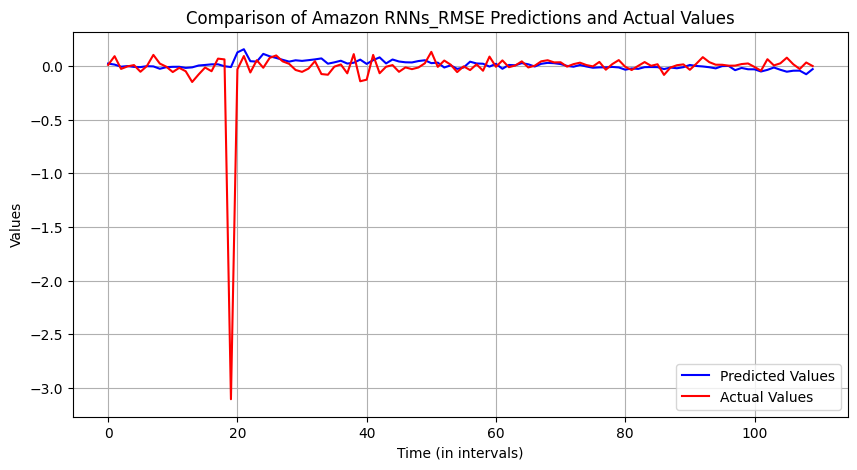

In [ ]:
# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(amazon_rnns_rmse_predictions, label='Predicted Values', color='blue')
plt.plot(amazon_rnns_rmse_actuals, label='Actual Values', color='red')
plt.title('Comparison of Amazon RNNs_RMSE Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

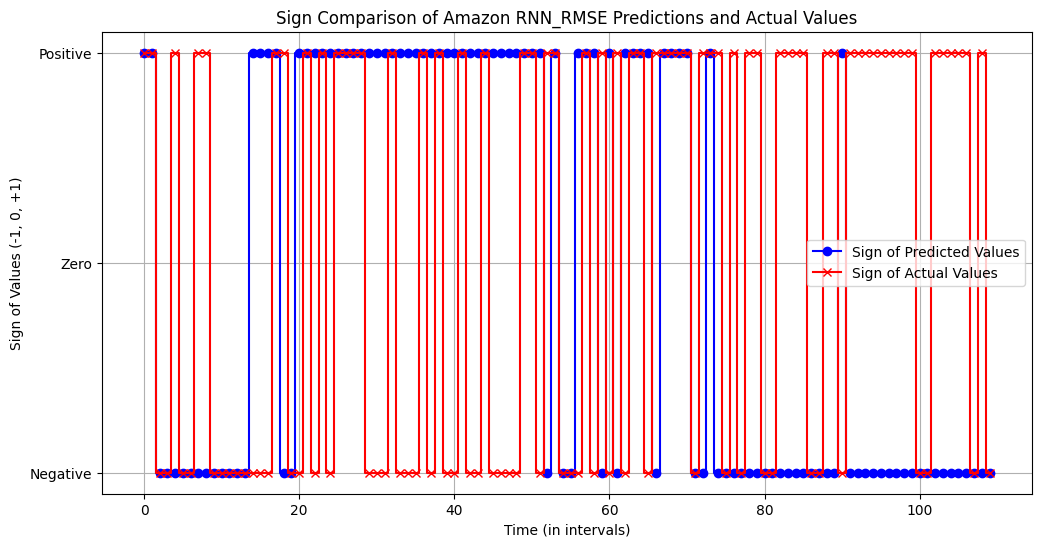

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions_rnn = np.sign(amazon_rnns_rmse_predictions)
signs_actuals_rnn = np.sign(amazon_rnns_rmse_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions_rnn)), signs_predictions_rnn, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals_rnn)), signs_actuals_rnn, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of Amazon RNN_RMSE Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

##### ANFIS

In [ ]:
X_amazon_train_anfis = torch.tensor(X_amazon_train_scaled, dtype=torch.float32)
y_amazon_train_anfis = torch.tensor(y_amazon_train, dtype=torch.float32)
X_amazon_val_anfis = torch.tensor(X_amazon_val_scaled, dtype=torch.float32)
y_amazon_val_anfis = torch.tensor(y_amazon_val, dtype=torch.float32)
X_amazon_test_anfis = torch.tensor(X_amazon_test_scaled, dtype=torch.float32)
y_amazon_test_anfis = torch.tensor(y_amazon_test, dtype=torch.float32)

In [ ]:
X_amazon_train_anfis.shape

torch.Size([840, 15])

In [ ]:
from anns import ANFIS_RMSE
input_dim = X_amazon_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.007

# Initialize the ANFIS model
amazon_anfis_rmse = ANFIS_RMSE(functions=functions, input_dim=input_dim)

# Train the model
amazon_anfis_rmse.fit(X_amazon_train_anfis, y_amazon_train_anfis
                      , X_amazon_val_anfis, y_amazon_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
amazon_anfis_rmse_predictions = amazon_anfis_rmse.predict(X_amazon_test_anfis)

Epoch 1/100, Train Loss: 0.0376, Validation Loss: 0.0105
Epoch 11/100, Train Loss: 0.0040, Validation Loss: 0.0015
Epoch 21/100, Train Loss: 0.0039, Validation Loss: 0.0015
Epoch 31/100, Train Loss: 0.0036, Validation Loss: 0.0014
Epoch 41/100, Train Loss: 0.0031, Validation Loss: 0.0016
Epoch 51/100, Train Loss: 0.0027, Validation Loss: 0.0017
Epoch 61/100, Train Loss: 0.0025, Validation Loss: 0.0020
Epoch 71/100, Train Loss: 0.0023, Validation Loss: 0.0023
Epoch 81/100, Train Loss: 0.0021, Validation Loss: 0.0021
Epoch 91/100, Train Loss: 0.0020, Validation Loss: 0.0023
Best Validation Loss: 0.0013


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
amazon_anfis_rmse_predictions = amazon_anfis_rmse_predictions.detach().cpu().numpy()
amazon_anfis_rmse_actuals = y_amazon_test_anfis.detach().cpu().numpy()

# Function to convert values to 1 and 0 based on sign
# Positive sign (including zero for simplicity in binary classification) will be 1
# Negative sign will be 0
def sign_classify(values):
    return (np.sign(values) >= 0).astype(int)

# Classify both predictions and actuals
predicted_signs = sign_classify(amazon_anfis_rmse_predictions)
actual_signs = sign_classify(amazon_anfis_rmse_actuals)

# Calculate metrics directly comparing predicted and actual signs
amazon_anfis_rmse_accuracy = accuracy_score(actual_signs, predicted_signs)
amazon_anfis_rmse_precision = precision_score(actual_signs, predicted_signs)
amazon_anfis_rmse_recall = recall_score(actual_signs, predicted_signs)
amazon_anfis_rmse_f1 = f1_score(actual_signs, predicted_signs)

# Print the classification metrics
print("Accuracy:", amazon_anfis_rmse_accuracy)
print("Precision:", amazon_anfis_rmse_precision)
print("Recall:", amazon_anfis_rmse_recall)
print("F1 Score:", amazon_anfis_rmse_f1)

Accuracy: 0.38333333333333336
Precision: 0.39285714285714285
Recall: 0.3548387096774194
F1 Score: 0.3728813559322034


###### Plots

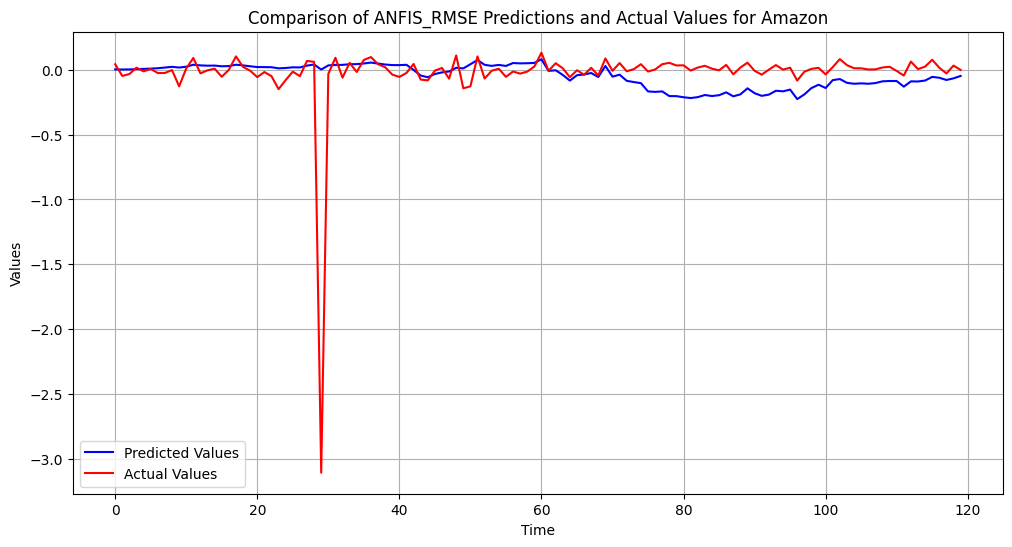

In [ ]:
# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(amazon_anfis_rmse_predictions, label='Predicted Values', color='blue')
plt.plot(amazon_anfis_rmse_actuals, label='Actual Values', color='red')
plt.title('Comparison of ANFIS_RMSE Predictions and Actual Values for Amazon')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

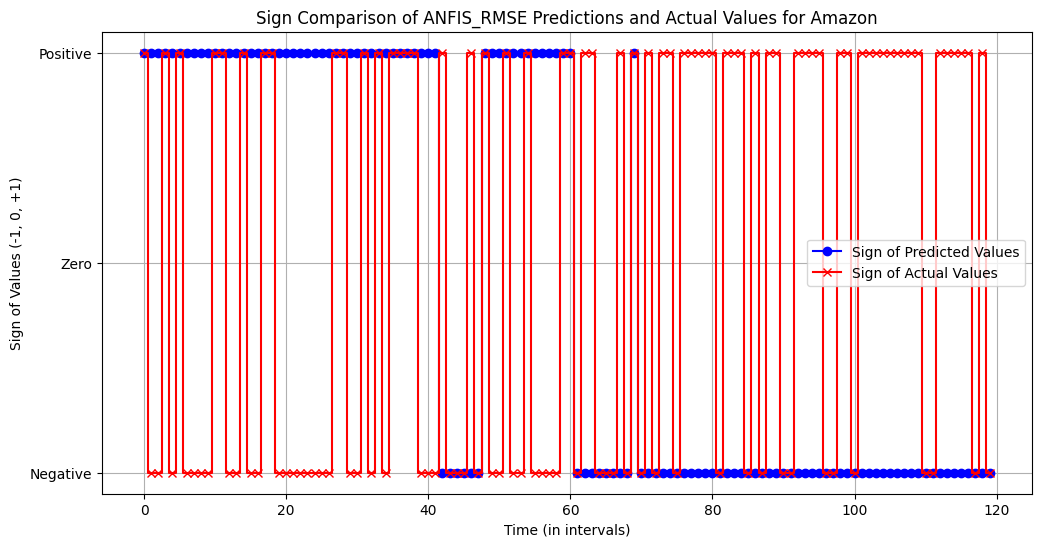

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions = np.sign(amazon_anfis_rmse_predictions)
signs_actuals = np.sign(amazon_anfis_rmse_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions)), signs_predictions, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals)), signs_actuals, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of ANFIS_RMSE Predictions and Actual Values for Amazon')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

#### Custom loss function

##### RNNs

In [ ]:
from anns import EnhancedSignAgreementLoss
# Initialize the RNN model
amazon_rnns_custom = SimpleRNN(input_size=15, hidden_size=20, num_layers=1, output_size=1)
optimizer = optim.Adam(amazon_rnns_custom.parameters(), lr=0.001)
loss_function = EnhancedSignAgreementLoss(loss_penalty=5000)
epochs = 100

best_model_state, best_val_loss = rnns(amazon_rnns_custom, amazon_train_loader, amazon_val_loader, epochs, optimizer, loss_function)

Epoch 1, Train Loss: 2166.676025390625, Val Loss: 2174.488037109375
Epoch 11, Train Loss: 2333.33740234375, Val Loss: 2330.731201171875
Epoch 21, Train Loss: 2333.33740234375, Val Loss: 2330.730712890625
Epoch 31, Train Loss: 1833.33837890625, Val Loss: 1894.53271484375
Epoch 41, Train Loss: 1000.0034790039062, Val Loss: 2330.730712890625
Epoch 51, Train Loss: 2666.670166015625, Val Loss: 2246.09521484375
Epoch 61, Train Loss: 2833.33642578125, Val Loss: 2220.0537109375
Epoch 71, Train Loss: 2833.338134765625, Val Loss: 1953.12646484375
Epoch 81, Train Loss: 1333.33544921875, Val Loss: 2096.355712890625
Epoch 91, Train Loss: 2500.004150390625, Val Loss: 2291.668701171875


In [ ]:
best_val_loss

tensor(1621.0953)

In [ ]:
amazon_rnns_custom.load_state_dict(best_model_state)
amazon_rnns_custom.eval()  # Set the model to evaluation mode

SimpleRNN(
  (rnn): RNN(15, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
amazon_predictions = []
amazon_actuals = []

with torch.no_grad():
    for inputs, labels in amazon_predict_loader:
        outputs = amazon_rnns_custom(inputs)
        if outputs.dim() > 1 and outputs.shape[1] == 1:
            outputs = outputs.squeeze(1)  # Make sure the output is [batch] if it's [batch, 1]

        # Store predictions and actual values
        amazon_predictions.extend(outputs.cpu().numpy())  # Convert tensor to numpy array if necessary
        amazon_actuals.extend(labels.cpu().numpy())

In [ ]:
amazon_rnns_custom_predictions = np.array(amazon_predictions)
amazon_rnns_custom_actuals = np.array(amazon_actuals)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming amazon_rnns_rmse_predictions and amazon_rnns_rmse_actuals are numpy arrays of predictions and actual values
# Convert predictions and actuals to binary classification problem (1 if positive or 0, 0 if negative)
amazon_rnns_custom_predicted_labels = (amazon_rnns_custom_predictions >= 0).astype(int)
amazon_rnns_custom_actual_labels = (amazon_rnns_custom_actuals >= 0).astype(int)

# Calculate classifier metrics
amazon_rnns_custom_accuracy = accuracy_score(amazon_rnns_custom_actual_labels, amazon_rnns_custom_predicted_labels)
amazon_rnns_custom_precision = precision_score(amazon_rnns_custom_actual_labels, amazon_rnns_custom_predicted_labels)
amazon_rnns_custom_recall = recall_score(amazon_rnns_custom_actual_labels, amazon_rnns_custom_predicted_labels)
amazon_rnns_custom_f1 = f1_score(amazon_rnns_custom_actual_labels, amazon_rnns_custom_predicted_labels)

# Print the classification metrics
print("Accuracy:", amazon_rnns_custom_accuracy)
print("Precision:", amazon_rnns_custom_precision)
print("Recall:", amazon_rnns_custom_recall)
print("F1 Score:", amazon_rnns_custom_f1)

Accuracy: 0.5454545454545454
Precision: 0.5737704918032787
Recall: 0.5932203389830508
F1 Score: 0.5833333333333334


###### Plots

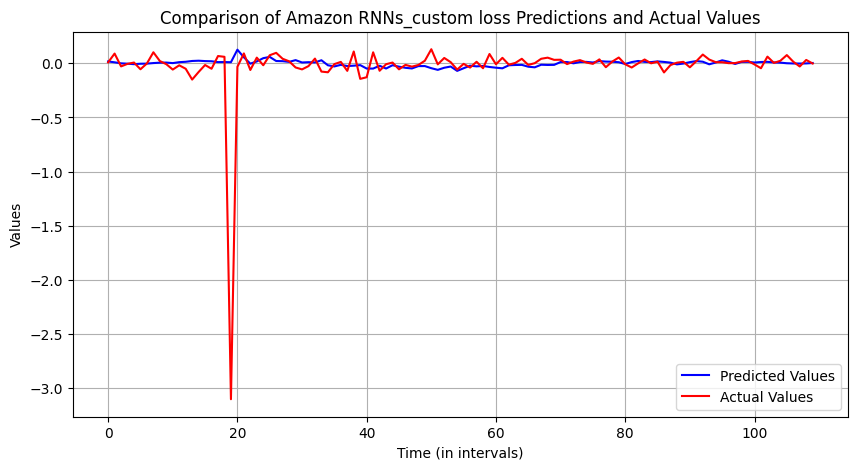

In [ ]:
# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(amazon_rnns_custom_predictions, label='Predicted Values', color='blue')
plt.plot(amazon_rnns_custom_actuals, label='Actual Values', color='red')
plt.title('Comparison of Amazon RNNs_custom loss Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

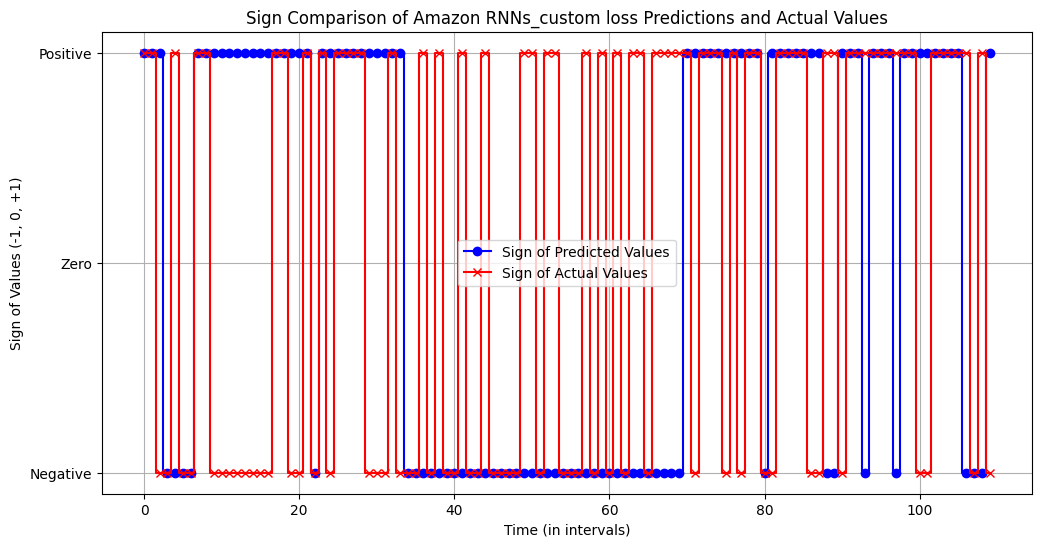

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions_rnn = np.sign(amazon_rnns_custom_predictions)
signs_actuals_rnn = np.sign(amazon_rnns_custom_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions_rnn)), signs_predictions_rnn, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals_rnn)), signs_actuals_rnn, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of Amazon RNNs_custom loss Predictions and Actual Values')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()

##### ANFIS

In [ ]:
from anns import ANFIS_CustomLoss

input_dim = X_amazon_train_anfis.shape[1]  # Number of features
functions = 10  # Number of Gaussian functions in the model
epochs = 100
learning_rate = 0.007

# Initialize the ANFIS model
amazon_anfis_custom = ANFIS_CustomLoss(functions=functions, input_dim=input_dim, loss_penalty=5000)

# Train the model
amazon_anfis_custom.fit(X_amazon_train_anfis, y_amazon_train_anfis
                      , X_amazon_val_anfis, y_amazon_val_anfis
                      , epochs, learning_rate)

# Predict on the test set
amazon_anfis_custom_predictions = amazon_anfis_custom.predict(X_amazon_test_anfis)

Epoch 1/100, Train Loss: 2327.4147, Val Loss: 2125.0090
Epoch 11/100, Train Loss: 2041.6707, Val Loss: 1833.3346
Epoch 21/100, Train Loss: 1839.2896, Val Loss: 1875.0015
Epoch 31/100, Train Loss: 1821.4323, Val Loss: 2062.5015
Epoch 41/100, Train Loss: 1517.8605, Val Loss: 1729.1681
Epoch 51/100, Train Loss: 1345.2412, Val Loss: 1687.5015
Epoch 61/100, Train Loss: 1238.0981, Val Loss: 1937.5019
Epoch 71/100, Train Loss: 1291.6693, Val Loss: 1895.8358
Epoch 81/100, Train Loss: 1178.5738, Val Loss: 1854.1692
Epoch 91/100, Train Loss: 1136.9070, Val Loss: 1729.1695
Best Validation Loss: 1562.5028


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
amazon_anfis_custom_predictions = amazon_anfis_custom_predictions.detach().cpu().numpy()
amazon_anfis_custom_actuals = y_amazon_test_anfis.detach().cpu().numpy()

# Function to convert values to 1 and 0 based on sign
def sign_classify(values):
    # Convert positive and zero values to 1, and negative values to 0
    return (np.sign(values) >= 0).astype(int)

# Classify both predictions and actuals
predicted_signs = sign_classify(amazon_anfis_custom_predictions)
actual_signs = sign_classify(amazon_anfis_custom_actuals)

# Calculate metrics directly using predicted and actual signs
amazon_anfis_custom_accuracy = accuracy_score(actual_signs, predicted_signs)
amazon_anfis_custom_precision = precision_score(actual_signs, predicted_signs)
amazon_anfis_custom_recall = recall_score(actual_signs, predicted_signs)
amazon_anfis_custom_f1 = f1_score(actual_signs, predicted_signs)

# Print the classification metrics
print("Accuracy:", amazon_anfis_custom_accuracy)
print("Precision:", amazon_anfis_custom_precision)
print("Recall:", amazon_anfis_custom_recall)
print("F1 Score:", amazon_anfis_custom_f1)

Accuracy: 0.425
Precision: 0.4222222222222222
Recall: 0.3064516129032258
F1 Score: 0.35514018691588783


###### Plots

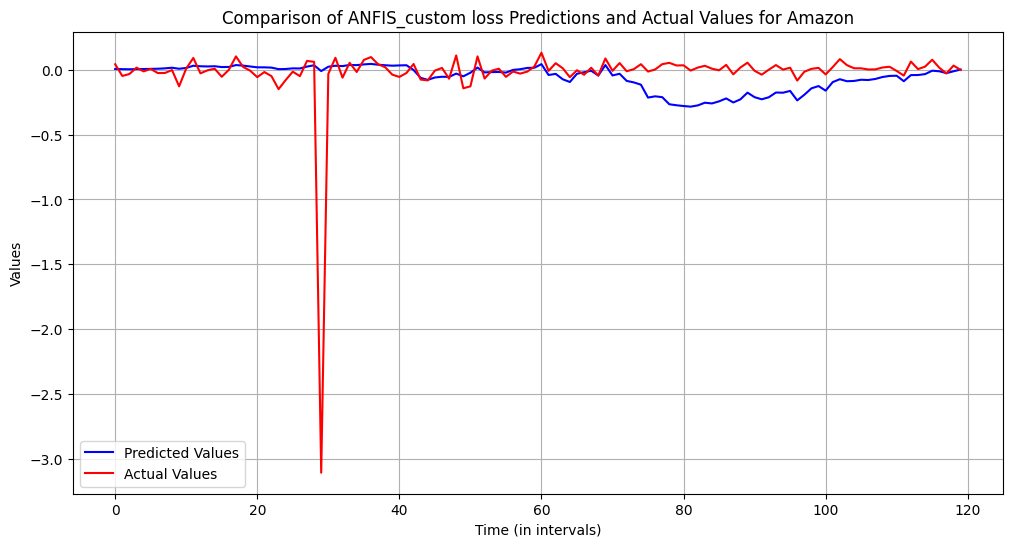

In [ ]:
# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(amazon_anfis_custom_predictions, label='Predicted Values', color='blue')
plt.plot(amazon_anfis_custom_actuals, label='Actual Values', color='red')
plt.title('Comparison of ANFIS_custom loss Predictions and Actual Values for Amazon')
plt.xlabel('Time (in intervals)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

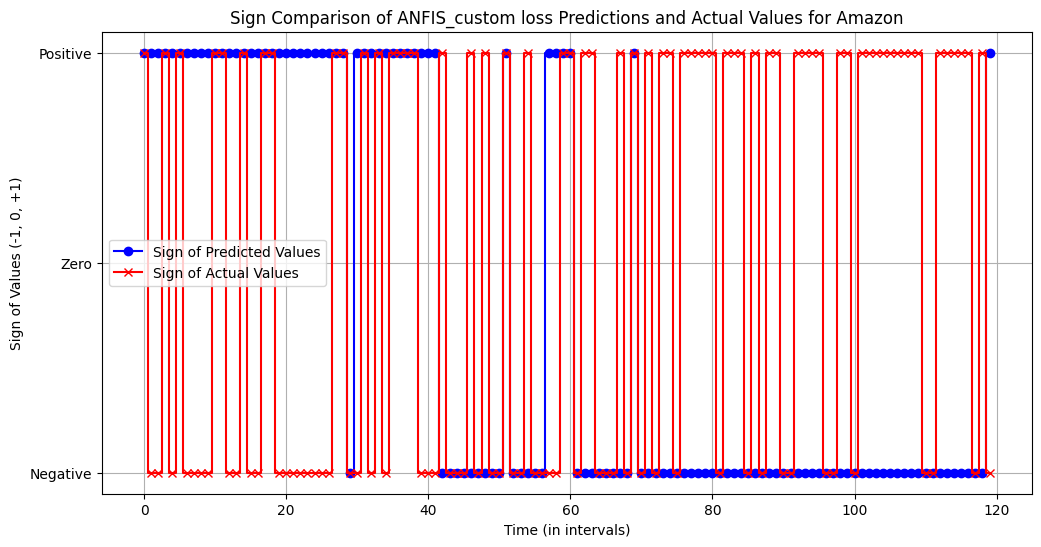

In [ ]:
# Calculate the signs of the predictions and actual values
signs_predictions = np.sign(amazon_anfis_custom_predictions)
signs_actuals = np.sign(amazon_anfis_custom_actuals)

# Create a plot
plt.figure(figsize=(12, 6))
plt.step(range(len(signs_predictions)), signs_predictions, label='Sign of Predicted Values', where='mid', marker='o', linestyle='-', color='blue')
plt.step(range(len(signs_actuals)), signs_actuals, label='Sign of Actual Values', where='mid', marker='x', linestyle='-', color='red')
plt.title('Sign Comparison of ANFIS_custom loss Predictions and Actual Values for Amazon')
plt.xlabel('Time (in intervals)')
plt.ylabel('Sign of Values (-1, 0, +1)')
plt.yticks([-1, 0, 1], ['Negative', 'Zero', 'Positive'])  # setting y-tick labels for clarity
plt.legend()
plt.grid(True)
plt.show()